In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
)
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    auc,
    roc_curve,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score

df = pd.read_excel("./activity_sample.xlsx")

In [3]:
df = df.drop("Unnamed: 0", axis=1)

In [4]:
df["action"].value_counts()

action
Viewed           1750
ChangedSpeed     1234
NavigatedTo      1095
JumpedTo          687
Ended             648
Started           579
ChangedVolume     307
Restarted          93
Paused             51
Resumed            32
Name: count, dtype: int64

| features | 정보 |
| --- | --- |
| userid | 사용자 id |
| learning_seq | 학습 순서 |
| mcode | 콘텐츠 고유 id |
| learning_action_seq | 학습 중 행동 순서 |
| event_type | 이벤트 유형 |
| action | 이벤트에 포함되는 행동 내용 |
| object_type | 활동 대상 |
| timestamp | 해당 학습 중 행동이 발생한 시간 |
| gender | 사용자의 성별 |
| grade | 사용자의 학년 |
| memberstatus | 회원 상태(정회원, 준회원, 탈퇴회원 등) |
| memberstatus_change | 월 중 회원 상태 변화 |
| 'day_01_status' ~ 'day_31_status' | 1일 ~ 31일 회원 상태 |
| change_date | 회원 상태 변화까지 걸린 시간 |

In [5]:
le = LabelEncoder()
df["userid_encoded"] = le.fit_transform(df["userid"])
df["mcode_encoded"] = le.fit_transform(df["mcode"])
df["object_type_encoded"] = le.fit_transform(df["object_type"])
# df['action_encoded'] = le.fit_transform(df['action'])

In [6]:
df[["mcode_encoded", "mcode"]].value_counts()

mcode_encoded  mcode       
128            T0SE52U09001    283
21             T0KE52U02003    265
25             T0KE52U02007    190
105            T0NE52U11002    184
1              T0EE52U02002    183
                              ... 
72             T0ME52U22038      1
60             T0ME52U21014      1
164            T0WE90U01016      1
163            T0WE90U01002      1
196            T9EE52U75001      1
Name: count, Length: 205, dtype: int64

In [7]:
df[["object_type_encoded", "object_type"]].value_counts()

object_type_encoded  object_type    
1                    VideoObject        3631
0                    DigitalResource    2844
2                    WebPage               1
Name: count, dtype: int64

In [8]:
df["userid_encoded"].value_counts()

userid_encoded
25    782
18    571
5     432
29    410
22    389
12    324
10    323
11    312
1     306
4     306
9     285
21    202
16    198
15    192
24    183
13    179
7     167
2     167
6     161
20    144
3     103
26     92
23     89
0      46
8      42
17     35
14     17
19     15
28      3
27      1
Name: count, dtype: int64

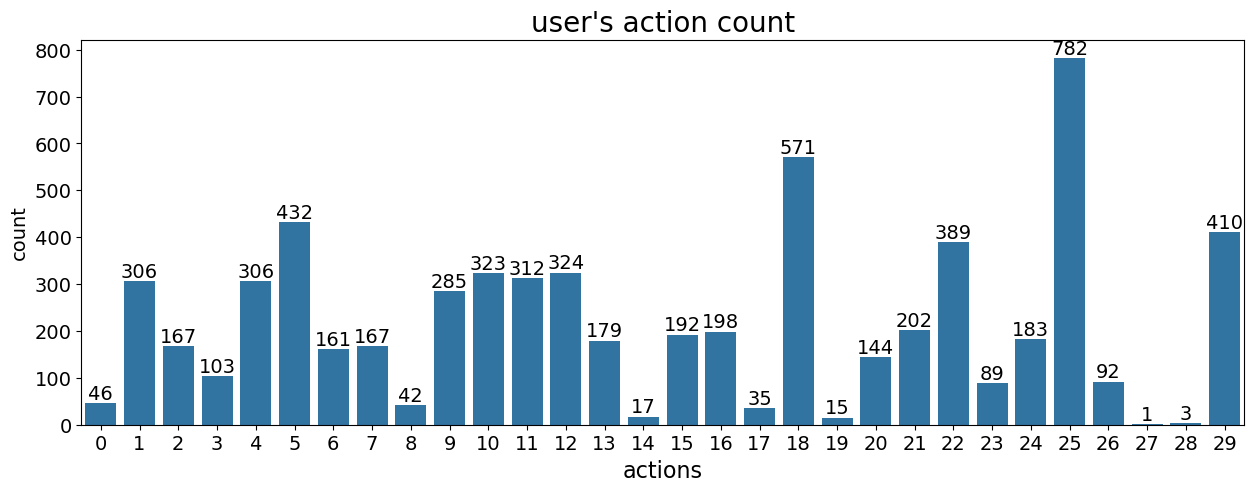

In [38]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(x=df["userid_encoded"])
plt.title("user's action count", fontsize=20)
plt.xlabel("actions", fontsize=16)
plt.ylabel("count", fontsize=14)
# plt.legend(fontsize=14)
plt.xticks(fontsize=14)  # x축 눈금 글자 크기
plt.yticks(fontsize=14)  # y축 눈금 글자 크기
for p in ax.patches:
    # p.patches는 각 막대의 패치 객체를 포함합니다.
    height = p.get_height()  # 막대의 높이
    ax.text(
        p.get_x() + p.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=14,
        color="black",
    )

In [10]:
pre = pd.DataFrame(
    df.loc[(df["userid_encoded"] == 25)]
    .sort_values(["timestamp", "learning_action_seq"])
    .reset_index()
)

In [11]:
pre["action"]

0           Viewed
1      NavigatedTo
2           Viewed
3      NavigatedTo
4           Viewed
          ...     
777       JumpedTo
778          Ended
779         Viewed
780    NavigatedTo
781         Viewed
Name: action, Length: 782, dtype: object

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


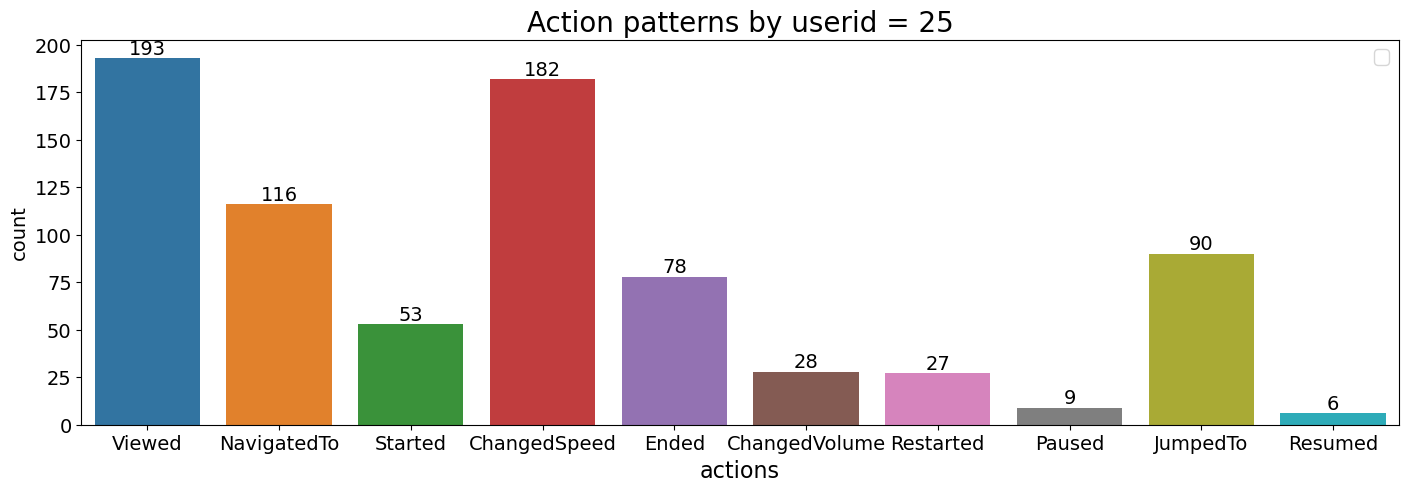

In [12]:
plt.figure(figsize=(17, 5))
ax = sns.countplot(x=pre["action"], hue=pre["action"])
plt.title("Action patterns by userid = 25", fontsize=20)
plt.xlabel("actions", fontsize=16)
plt.ylabel("count", fontsize=14)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)  # x축 눈금 글자 크기
plt.yticks(fontsize=14)  # y축 눈금 글자 크기
for p in ax.patches:
    # p.patches는 각 막대의 패치 객체를 포함합니다.
    height = p.get_height()  # 막대의 높이
    ax.text(
        p.get_x() + p.get_width() / 2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=14,
        color="black",
    )

In [13]:
X = pd.DataFrame(
    df.loc[
        df["userid_encoded"] == 25,
        [
            "mcode_encoded",
            "learning_seq",
            "learning_action_seq",
            "object_type_encoded",
            "timestamp",
        ],
    ].sort_values(["timestamp", "learning_action_seq"])
)
X

,mcode_encoded,learning_seq,learning_action_seq,object_type_encoded,timestamp
5188,104,1,1,0,2022-09-01 19:35:09.624
5189,104,1,2,0,2022-09-01 19:35:21.376
5190,104,1,3,0,2022-09-01 19:35:21.584
5191,104,1,4,0,2022-09-01 19:35:52.562
5192,104,1,5,0,2022-09-01 19:35:52.718
...,...,...,...,...,...
5965,4,1,21,1,2022-09-25 17:31:03.382
5966,4,1,22,1,2022-09-25 17:31:03.382
5967,4,1,23,0,2022-09-25 17:31:34.500
5968,4,1,24,0,2022-09-25 17:31:34.856


In [14]:
features = [
    "learning_seq",
    "learning_action_seq",
    "mcode_encoded",
    "object_type_encoded",
]

In [15]:
y = df.loc[
    df["userid_encoded"] == 25,
    ["object_type_encoded", "action", "timestamp", "learning_action_seq"],
].sort_values(["timestamp", "learning_action_seq"])
y

,object_type_encoded,action,timestamp,learning_action_seq
5188,0,Viewed,2022-09-01 19:35:09.624,1
5189,0,NavigatedTo,2022-09-01 19:35:21.376,2
5190,0,Viewed,2022-09-01 19:35:21.584,3
5191,0,NavigatedTo,2022-09-01 19:35:52.562,4
5192,0,Viewed,2022-09-01 19:35:52.718,5
...,...,...,...,...
5965,1,JumpedTo,2022-09-25 17:31:03.382,21
5966,1,Ended,2022-09-25 17:31:03.382,22
5967,0,Viewed,2022-09-25 17:31:34.500,23
5968,0,NavigatedTo,2022-09-25 17:31:34.856,24


In [16]:
# X_train, X_test, y_train, y_test = train_test_split(X[features],y['action'],test_size=0.2, random_state=12345)

In [17]:
split_index = int(len(X) * 0.8)  # 80%를 훈련 데이터로 사용

X_train = X.iloc[:split_index, [0, 1, 2, 3]]
y_train = y.iloc[:split_index, 1]
X_test = X.iloc[split_index:, [0, 1, 2, 3]]
y_test = y.iloc[split_index:, 1]

In [18]:
X_train.count()
X_test.count()

mcode_encoded          157
learning_seq           157
learning_action_seq    157
object_type_encoded    157
dtype: int64

In [73]:
models = {
    "rfc": RandomForestClassifier(n_estimators=1000, random_state=12345),
    "lr": LogisticRegression(random_state=12345),
    "gb": GradientBoostingClassifier(n_estimators=1000, random_state=12345),
    "svm": SVC(
        probability=True, random_state=12345
    ),  # 확률 예측을 위해 probability = True
    "knn": KNeighborsClassifier(),
}

# 모델 학습 및 평가
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy

# 결과 출력
results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
print(results_df)

c:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  Model  Accuracy
0   rfc  0.554140
1    lr  0.439490
2    gb  0.503185
3   svm  0.242038
4   knn  0.331210


In [74]:
voting_clf_soft = VotingClassifier(
    estimators=[
        ("rfc", models["rfc"]),
        ("lr", models["lr"]),
        ("gb", models["gb"]),
        ("svm", models["svm"]),
        ("knn", models["knn"]),
    ],
    voting="soft",
)

# 모델 학습 및 평가
voting_clf_soft.fit(X_train, y_train)
y_pred = voting_clf_soft.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Soft Voting Classifier Accuracy: {accuracy:.4f}")

c:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Soft Voting Classifier Accuracy: 0.5287


In [21]:
# model = GradientBoostingClassifier(n_estimators=100, random_state=12345)

# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test,y_pred)
# accuracy

In [22]:
voting_clf_soft.score(X_train, y_train)

0.9856

In [23]:
cm = confusion_matrix(y_test, y_pred)

In [40]:
print(y_test[-5:].reset_index().drop("index", axis=1))

        action
0     JumpedTo
1        Ended
2       Viewed
3  NavigatedTo
4       Viewed


In [25]:
y_pred_df = pd.DataFrame(y_pred)

In [43]:
print(y_pred_df[:5])

      predicted         truth  bool
0   NavigatedTo   NavigatedTo  True
1        Viewed        Viewed  True
2   NavigatedTo   NavigatedTo  True
3        Viewed        Viewed  True
4  ChangedSpeed  ChangedSpeed  True


In [27]:
label_order = [
    "ChangedSpeed",
    "ChangedVolume",
    "Ended",
    "JumpedTo",
    "NavigatedTo",
    "Paused",
    "Restarted",
    "Started",
    "Viewed",
]

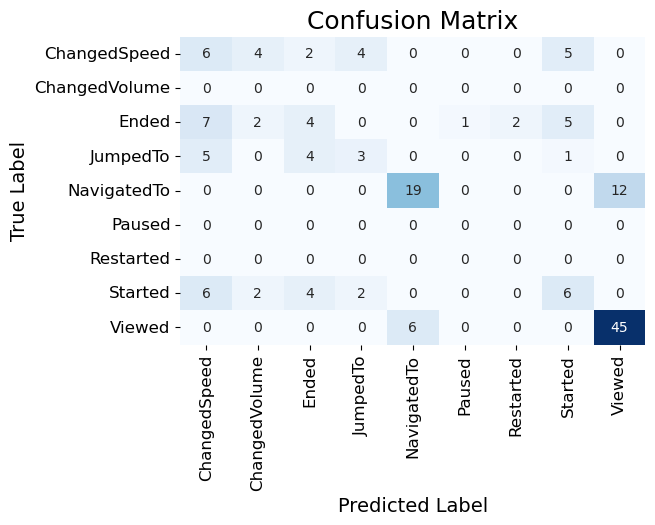

In [28]:
# 혼동 행렬
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=label_order,
    yticklabels=label_order,
)
plt.title("Confusion Matrix", fontsize=18)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12)  # x축 눈금 글자 크기
plt.yticks(fontsize=12)  # y축 눈금 글자 크기
plt.show()

In [29]:
le.classes_

array(['DigitalResource', 'VideoObject', 'WebPage'], dtype=object)

In [30]:
list(y_pred).count("Started")

17

In [65]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df = y_pred_df.rename(columns={0: "predicted"})
y_pred_df["truth"] = y_test.values
y_pred_df["bool"] = y_pred_df["truth"] == y_pred_df["predicted"]
y_pred_df.loc[y_pred_df["bool"] == True, "bool"] = "correct"
y_pred_df.loc[y_pred_df["bool"] == False, "bool"] = "wrong"
y_pred_df.head(10)

C:\Users\user\AppData\Local\Temp\ipykernel_27724\4091131703.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  y_pred_df.loc[y_pred_df['bool'] == True, 'bool'] = 'correct'


,predicted,truth,bool
0,NavigatedTo,NavigatedTo,correct
1,Viewed,Viewed,correct
2,NavigatedTo,NavigatedTo,correct
3,Viewed,Viewed,correct
4,ChangedSpeed,ChangedSpeed,correct
5,ChangedSpeed,ChangedSpeed,correct
6,ChangedSpeed,ChangedSpeed,correct
7,Started,ChangedSpeed,wrong
8,ChangedSpeed,Ended,wrong
9,ChangedSpeed,Started,wrong


In [46]:
y_pred_df["bool"].value_counts()

bool
True     83
False    74
Name: count, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


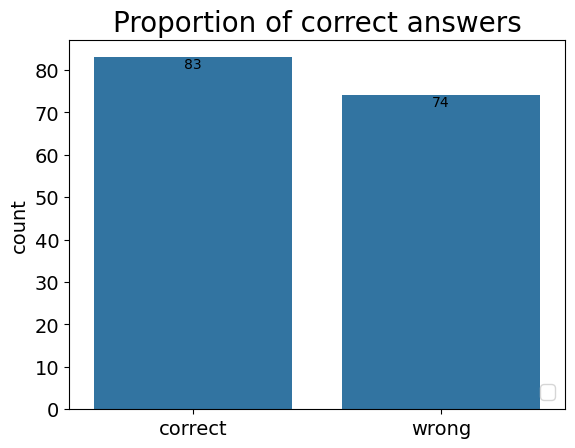

In [78]:
ax = sns.countplot(x=y_pred_df["bool"])

plt.title("Proportion of correct answers", fontsize=20)
plt.xlabel("", fontsize=14)
plt.ylabel("count", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.xticks(fontsize=14)  # x축 눈금 글자 크기
plt.yticks(fontsize=14)  # y축 눈금 글자 크기
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{int(height)}",
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="top",
    )

In [33]:
y_pred_prob = voting_clf_soft.predict_proba(X_test)[:, 1]
y_pred_prob.round(2) * 100

array([ 2.,  2.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,  8., 14.,
       47., 38., 44., 40., 16., 17.,  8.,  8.,  8.,  8.,  7.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  2.,  2.,  6., 15.,  1.,  1.,  4.,
        4.,  3.,  3.,  4.,  4.,  4.,  8., 17.,  9.,  9.,  8.,  1.,  1.,
        4.,  4.,  4.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        2.,  2.,  1.,  2.,  2.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  1.,
        1.,  1.,  1., 38., 37.,  7.,  2.,  2.,  1.,  1.,  1.,  1.,  1.,
        1.,  1., 25., 15.,  6.,  2.,  2.,  2.,  1.,  1.,  1.,  1.,  2.,
        2.,  2.,  1.,  2.,  2.,  2.,  2.,  2.,  6., 10., 14.,  0.,  2.,
        2.,  2.,  6., 47., 49., 13.,  3.,  3., 10.,  3.,  2.,  2.,  2.,
        2.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  3.,  2.,  4.,  4.,  4.,  2.,  3.,  3.,  3.,  2.,  3.,
        3.])

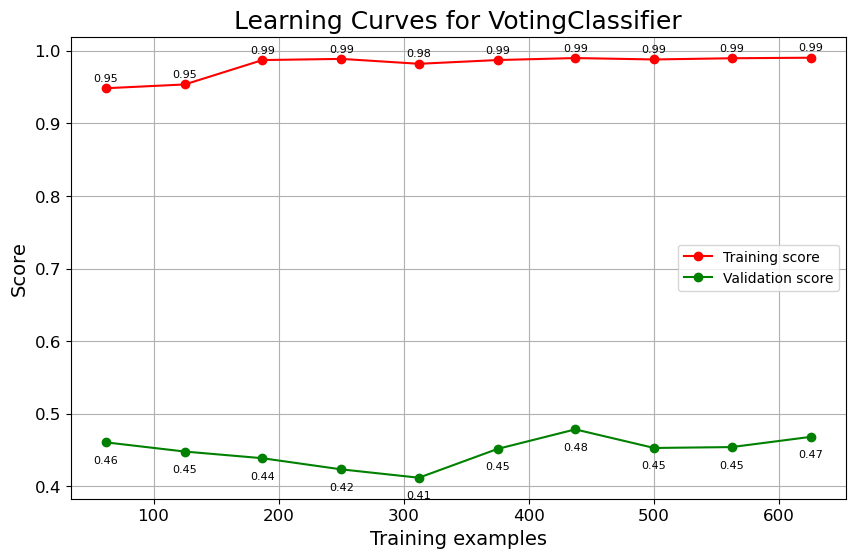

In [34]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, X, y, title="Learning Curves"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1, 10)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Validation score")
    for i in range(len(train_sizes)):
        plt.annotate(
            f"{train_scores_mean[i]:.2f}",
            (train_sizes[i], train_scores_mean[i]),
            textcoords="offset points",
            xytext=(0, 5),
            ha="center",
            fontsize=8,
        )
        plt.annotate(
            f"{test_scores_mean[i]:.2f}",
            (train_sizes[i], test_scores_mean[i]),
            textcoords="offset points",
            xytext=(0, -15),
            ha="center",
            fontsize=8,
        )
    plt.title(title, fontsize=18)
    plt.xlabel("Training examples", fontsize=14)
    plt.ylabel("Score", fontsize=14)
    plt.legend(loc="best")
    plt.grid(True)
    plt.xticks(fontsize=12)  # x축 눈금 글자 크기
    plt.yticks(fontsize=12)  # y축 눈금 글자 크기
    plt.show()


plot_learning_curve(
    voting_clf_soft,
    X[features],
    y["action"],
    title="Learning Curves for VotingClassifier",
)

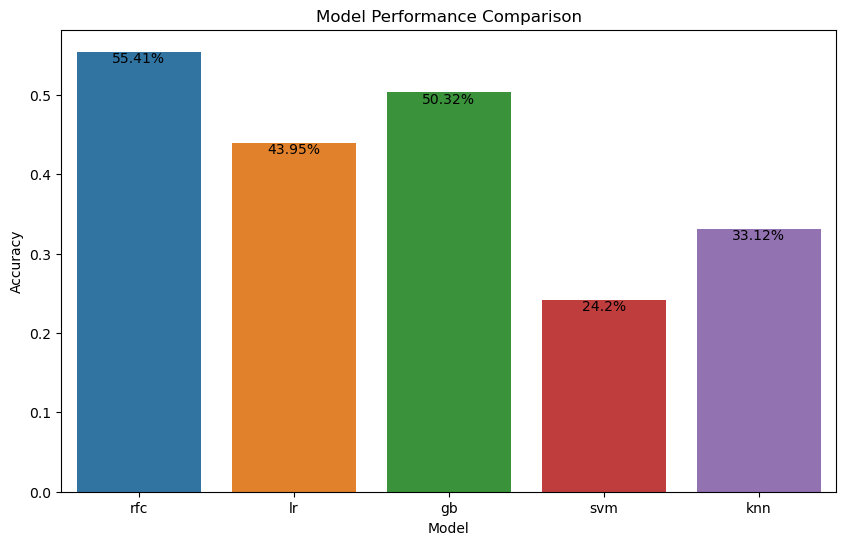

In [75]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=results.keys(), y=results.values(), hue=results.keys())
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{(height*100).round(2)}%",
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="top",
    )
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Performance Comparison")
plt.show()